In [5]:
using Pkg
Pkg.activate("..")

  Activating project at `~/PhD/MatrixProductBP.jl`


In [7]:
using Revise
using MatrixProductBP, MatrixProductBP.Models
using Graphs, IndexedGraphs, Statistics, Random, LinearAlgebra, TensorTrains, SparseArrays
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear)
using TensorTrains: summary_compact
using Plots, LaTeXStrings

In [20]:
seed = 1
rng = MersenneTwister(seed)

T = 10
N = 5
gg = barabasi_albert(N, 2, 1; rng, complete=true)
g = IndexedBiDiGraph(gg)

β = 0.5
h = 0.2
m⁰ = 0.7
K = 100
σ = 1/100

J = zeros(nv(g),nv(g))
for i in axes(J)[1], j in axes(J)[2]
    j>i && continue
    if has_edge(gg,i,j)
        # J[i,j] = 2*rand(rng)-1
        # J[i,j] = rand(rng)
        J[i,j] = 1.0
        J[j,i] = J[i,j]
    end
end

ϕᵢ = [t == 0 ? [(1-m⁰)/2, (1+m⁰)/2] : ones(2) for t in 0:T]
ψ_neutral = [ones(2,2) for t in 0:T]
ϕ = fill(ϕᵢ, nv(g))

w = [fill(HomogeneousGlauberFactor(1.0, h, β), T+1) for i in vertices(g)]
bp = mpbp(g, w, fill(2, nv(g)), T; ϕ)

w_fourier = [fill(GlauberFactor([J[ed.src,ed.dst] for ed in inedges(g,i)], h, β), T+1) for i in vertices(g)]
bp_fourier = mpbp(ComplexF64, g, w_fourier, fill(2, nv(g)), T; ϕ)
;

In [19]:
nsamples = 10^5
sms = SoftMarginSampler(bp_fourier)
sample!(sms, nsamples)

m_mc = [mean(potts2spin.(X[i,:]) for X in sms.X) for i in 1:N]
σ_mc = [std([potts2spin.(X[i,:]) for X in sms.X]) ./ sqrt(nsamples) for i in 1:N]
;

SoftMargin sampling 100%|████████████████████████████████| Time: 0:00:01


In [21]:
bondsize = 15
maxiter = 10
tol = 1e-12

iters, cb = iterate!(bp; maxiter, svd_trunc=TruncBond(bondsize), tol)
m = real.(means(potts2spin, bp))

iters_fourier, cb_fourier = iterate_fourier!(bp_fourier, K; maxiter, σ, svd_trunc=TruncBond(bondsize), tol)
# iters_fourier, cb_fourier = iterate_fourier!(bp_fourier, K; maxiter=1, σ, svd_trunc=TruncBond(bondsize), tol, shuffle_nodes=false, nodes=[1,3,4,2])
m_fourier = real.(means(potts2spin, bp_fourier))
;

Running MPBP: iter 2    Time: 0:00:00

Running MPBP: iter 3    Time: 0:00:00

Fourier MPBP SVD truncation to bond size m'=15
  20%|▊   |  ETA: 0:00:45

Fourier MPBP SVD truncation to bond size m'=15
  30%|█▎  |  ETA: 0:00:45

Fourier MPBP SVD truncation to bond size m'=15
  40%|█▋  |  ETA: 0:00:42

Fourier MPBP SVD truncation to bond size m'=15
 100%|████| Time: 0:00:35


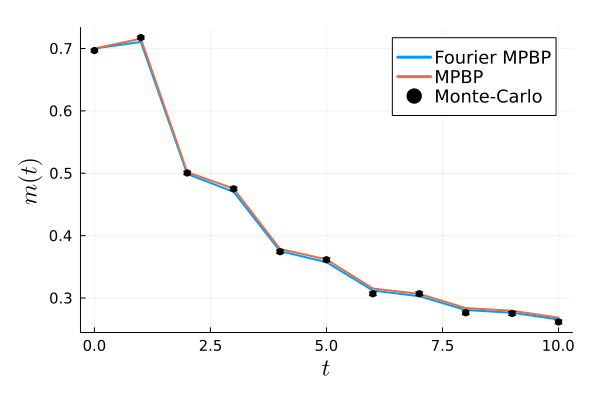

In [22]:
i = 2
y_mc = m_mc[i]
err_mc = σ_mc[i]
y_fourier = m_fourier[i]

T = length(y_fourier) - 1
plba = plot(legend=:topright, margin=5Plots.mm,
            xlabelfontsize=16,
            ylabelfontsize=16,
            legendfontsize=12,
            tickfontsize=10,
            size=(600,400),
            xlabel=L"t",
            ylabel=L"m(t)")

plot!(plba, 0:T, y_fourier[1:end], lw=2, label="Fourier MPBP")
plot!(plba, 0:T, m[i,1:end], lw=2, label="MPBP")
plot!(plba, 0:T, y_mc[1:end], yerr=err_mc, c=:black, st=:scatter, marker=:dot, label="Monte-Carlo")

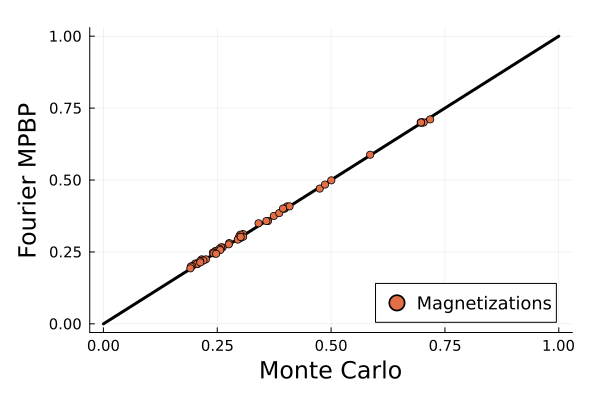

In [23]:
y_fourier_sc = reduce(vcat, y for y in m_fourier)
y_mc_sc = reduce(vcat, y for y in m_mc)
pl2ba = plot(legend=:bottomright, margin=5Plots.mm,
            xlabelfontsize=16,
            ylabelfontsize=16,
            legendfontsize=12,
            tickfontsize=10,
            size=(600,400),
            xlabel="Monte Carlo",
            ylabel="Fourier MPBP")

plot!(pl2ba, 0.0:0.1:1.0, 0.0:0.1:1.0, label="", c=:black, lw=3)
plot!(pl2ba, y_mc_sc, y_fourier_sc, st=:scatter, markerstrokecolor=:black, label="Magnetizations")

In [112]:
using Tullio, TensorCast

function convolution(F::Vector{<:MPEM2{U1}}, J::Vector{U2}, P::Float64, T::Integer; K::Int=(size(F[1][1],3)-1)/2, svd_trunc=TruncThresh(1e-8), normaliz::Bool=true, scale::Float64=1.0, σ::Float64=1/100) where {U1<:Number, U2<:Real}

    function op((F₁, J₁, d₁), (F₂, J₂, d₂))
        K1 = (size(F₁[1],3)-1)/2 |> Int
        K2 = (size(F₂[1],3)-1)/2 |> Int
        @tullio Int_1[γ,α] := _fourier3int(α,γ,1.0,J₁,P*scale,d₁,d₂) α∈-K1:K1, γ∈-K:K
        @tullio Int_2[γ,β] := _fourier3int(β,γ,1.0,J₂,P*scale,d₂,d₁) β∈-K2:K2, γ∈-K:K
    
        GG = map(zip(F₁,F₂)) do (F₁ᵗ, F₂ᵗ)
            @tullio Gt1[m1,n1,γ,x] := F₁ᵗ[m1,n1,α,x] * Int_1[γ,α]
            @tullio Gt2[m2,n2,γ,x] := F₂ᵗ[m2,n2,β,x] * Int_2[γ,β]
            @tullio Gt[m1,m2,n1,n2,γ,x] := 4/(P*scale*(d₁+d₂)) * Gt1[m1,n1,γ,x] * Gt2[m2,n2,γ,x]
            @cast Gᵗ[(m1,m2),(n1,n2),γ,x] := Gt[m1,m2,n1,n2,γ,x]
            return collect(Gᵗ)
        end
    
        G = fourier_tensor_train(GG, z=F₁.z*F₂.z)
        compress!(G; svd_trunc)
        normaliz && normalize_eachmatrix!(G)
        any(any(isnan, Gᵗ) for Gᵗ in G) && @error "NaN in Fourier tensor train"
        return (G, 1.0, d₁+d₂)
    end

    ttinit = [exp(-2*π^2 * α^2 * σ^2 / (P*scale)^2) for _ in 1:1, _ in 1:1, α in -K:K, _ in 1:2]

    ginit = [ComplexF64.(ttinit) for _ in 1:T+1]
    ginit_tt = fourier_tensor_train(ginit)
    normalize_eachmatrix!(ginit_tt)
    Ginit = (ginit_tt, 1.0, 1)


    # TTinit = [[1/2 for _ in 1:1, _ in 1:1, y in 1:2, x in 1:2] for _ in 1:T+1] |> TensorTrain
    # Ginit = (fourier_tensor_train_spin(TTinit, K, Inf, P, 0.0), 1.0, 0)
    G, full = cavity(zip(F,J,fill(1,length(F))) |> collect, op, Ginit)
    return G, full
end

function _fourier3int(α::Int, γ::Int, w::Real, J::Float64, Pscale::Float64, d₁::Integer, d₂::Integer)
    d₁₂ = d₁ + d₂
    kαγ = 2π * (d₁₂*α - d₁*J*γ) / (d₁*d₁₂*Pscale)
    iszero(kαγ) ? w : sin(kαγ*w)/kαγ
end

function op((F₁, J₁, d₁), (F₂, J₂, d₂); dᵢ=3, P=2.0, scale=1+ceil(dᵢ/4)/(dᵢ+1), normaliz=true)
    K1 = (size(F₁[1],3)-1)/2 |> Int
    K2 = (size(F₂[1],3)-1)/2 |> Int
    @tullio Int_1[γ,α] := _fourier3int(α,γ,d₁*scale,J₁,P*scale,d₁,d₂) α∈-K1:K1, γ∈-K:K
    @tullio Int_2[γ,β] := _fourier3int(β,γ,d₂*scale,J₂,P*scale,d₂,d₁) β∈-K2:K2, γ∈-K:K

    GG = map(zip(F₁,F₂)) do (F₁ᵗ, F₂ᵗ)
        @tullio Gt1[m1,n1,γ,x] := F₁ᵗ[m1,n1,α,x] * Int_1[γ,α]
        @tullio Gt2[m2,n2,γ,x] := F₂ᵗ[m2,n2,β,x] * Int_2[γ,β]
        @tullio Gt[m1,m2,n1,n2,γ,x] := 4/(P*scale*(d₁+d₂)) * Gt1[m1,n1,γ,x] * Gt2[m2,n2,γ,x]
        @cast Gᵗ[(m1,m2),(n1,n2),γ,x] := Gt[m1,m2,n1,n2,γ,x]
        return collect(Gᵗ)
    end

    G = fourier_tensor_train(GG, z=F₁.z*F₂.z)
    compress!(G; svd_trunc)
    normaliz && normalize_eachmatrix!(G)
    any(any(isnan, Gᵗ) for Gᵗ in G) && @error "NaN in Fourier tensor train"
    return (G, 1.0, d₁+d₂)
end

op (generic function with 1 method)

In [113]:
dᵢ=3; P=2.0; scale=1+ceil(dᵢ/4)/(dᵢ+1); K=100; σ=1/100; svd_trunc=TruncBond(15)

ttinit = [exp(-2*π^2 * α^2 * σ^2 / (P*scale)^2) for _ in 1:1, _ in 1:1, α in -K:K, _ in 1:2]

ginit = [ComplexF64.(ttinit) for _ in 1:T+1]
ginit_tt = fourier_tensor_train(ginit)
normalize_eachmatrix!(ginit_tt)
Ginit = (ginit_tt, 1.0, 1)

F = [fourier_tensor_train_spin(μk, K, scale, P, σ) for μk in bp.μ[idx.(inedges(g,2))]]

3-element Vector{TensorTrain{ComplexF64, 4, OffsetArrays.OffsetArray{ComplexF64, 4, Array{ComplexF64, 4}}, LogarithmicNumbers.LogFloat64}}:
 TensorTrain{ComplexF64, 4, OffsetArrays.OffsetArray{ComplexF64, 4, Array{ComplexF64, 4}}, LogarithmicNumbers.LogFloat64}(OffsetArrays.OffsetArray{ComplexF64, 4, Array{ComplexF64, 4}}[[-0.03882671342773197 + 2.6627445779582784e-16im -0.04249905628536254 + 2.914594661812536e-16im;;; 0.03344902992678587 + 0.017011499933632934im 0.03661273592458911 + 0.018620496801089625im;;; -0.013596564104998762 - 0.029292145055670935im -0.014882566464488841 - 0.032062680859070616im;;; … ;;; -0.013596564104998762 + 0.029292145055670935im -0.014882566464488841 + 0.032062680859070616im;;; 0.03344902992678587 - 0.017011499933632934im 0.03661273592458911 - 0.018620496801089625im;;; -0.03882671342773197 - 2.6627445779582784e-16im -0.04249905628536254 - 2.914594661812536e-16im;;;; -0.04249905628536253 + 2.9145946618125364e-16im 0.03882671342773196 - 2.662744577958276e-16i

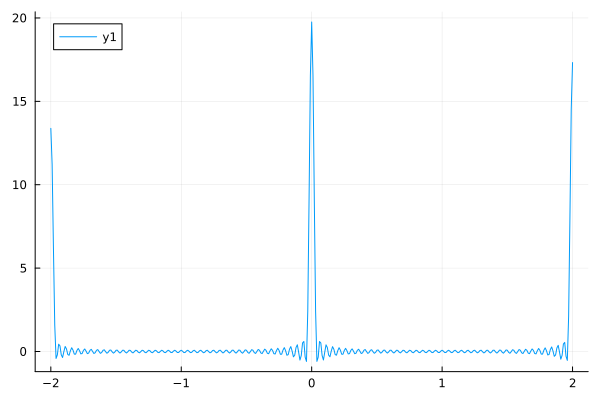

In [114]:
(F12, J12, d12) = op((F[1], 1.0, 1), (F[2], 1.0, 1); dᵢ=3, P=2.0, scale=1+ceil(dᵢ/4)/(dᵢ+1))
mF12 = marginals_fourier(F12, P*scale*d12)

xplot = -d12:0.01:d12
plot(xplot, (mF12[3]).(xplot))

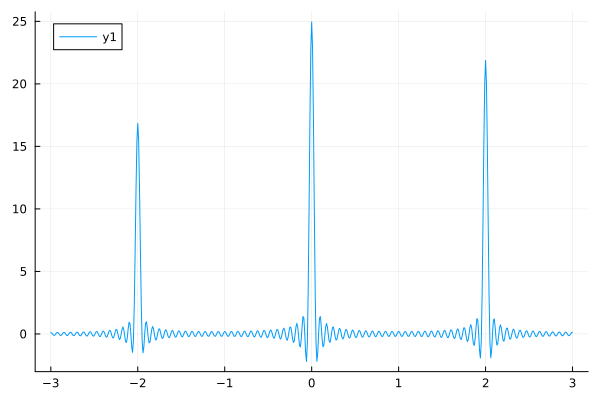

In [115]:
(F12i, J12i, d12i) = op((F12, J12, d12), Ginit; dᵢ=3, P=2.0, scale=1+ceil(dᵢ/4)/(dᵢ+1))
mF12i = marginals_fourier(F12i, P*scale*d12i)

xplot = -d12i:0.01:d12i
plot(xplot, (mF12i[3]).(xplot))

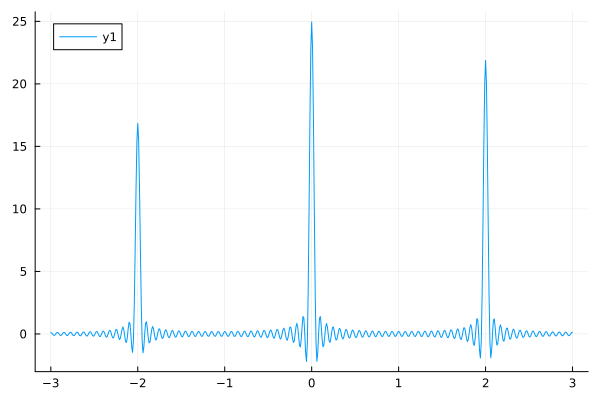

In [116]:
(Fi12, Ji12, di12) = op(Ginit, (F12, J12, d12); dᵢ=3, P=2.0, scale=1+ceil(dᵢ/4)/(dᵢ+1))
mFi12 = marginals_fourier(Fi12, P*scale*di12)

xplot = -di12:0.01:di12
plot(xplot, (mFi12[3]).(xplot))

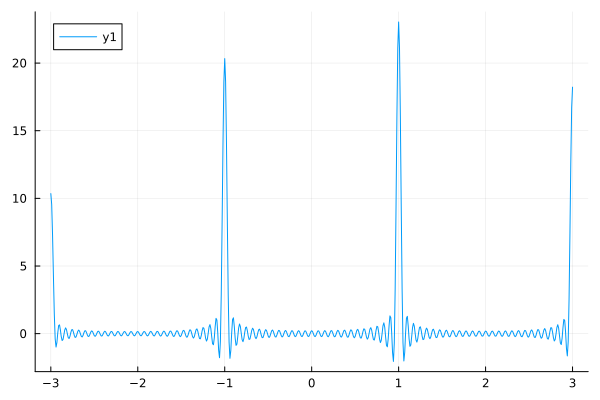

In [117]:
(F123, J123, d123) = op((F12, J12, d12), (F[3], 1.0, 1); dᵢ=3, P=2.0, scale=1+ceil(dᵢ/4)/(dᵢ+1))
mF123 = marginals_fourier(F123, P*scale*d123)

xplot = -d123:0.01:d123
plot(xplot, (mF123[3]).(xplot))

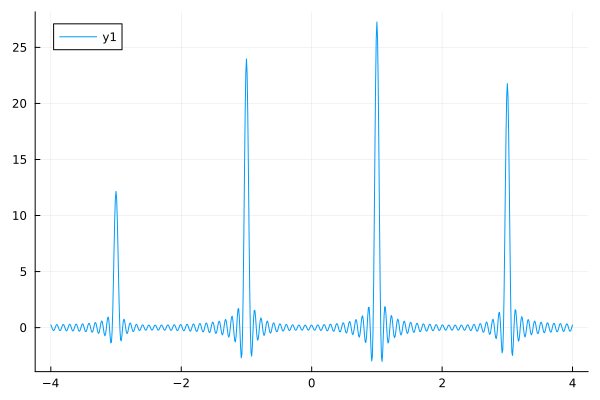

In [118]:
(F12i3, J12i3, d12i3) = op((F12i, J12i, d12i), (F[3], 1.0, 1); dᵢ=3, P=2.0, scale=1+ceil(dᵢ/4)/(dᵢ+1))
mF12i3 = marginals_fourier(F12i3, P*scale*d12i3)

xplot = -d12i3:0.01:d12i3
plot(xplot, (mF12i3[3]).(xplot))

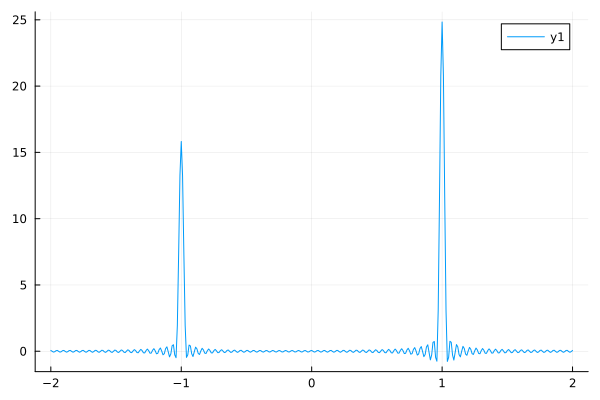

In [119]:
(F3i, J3i, d3i) = op((F[3], 1.0, 1), Ginit; dᵢ=3, P=2.0, scale=1+ceil(dᵢ/4)/(dᵢ+1))
mF3i = marginals_fourier(F3i, P*scale*d3i)

xplot = -d3i:0.01:d3i
plot(xplot, (mF3i[3]).(xplot))

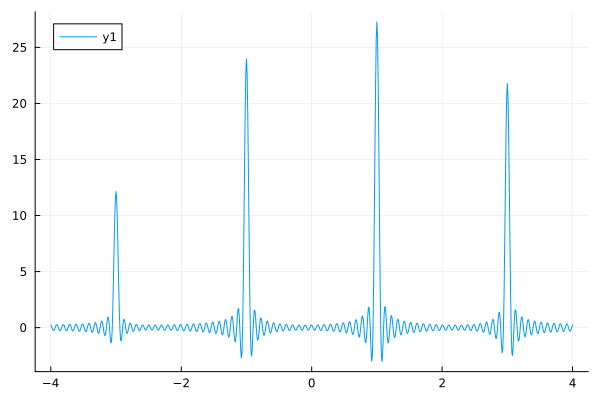

In [120]:
(F123i, J123i, d123i) = op((F12, J12, d12), (F3i, J3i, d3i); dᵢ=3, P=2.0, scale=1+ceil(dᵢ/4)/(dᵢ+1))
mF123i = marginals_fourier(F123i, P*scale*d123i)

xplot = -d123i:0.01:d123i
plot(xplot, (mF123i[3]).(xplot))